In [ ]:
# Find nearest neighbors in location space --> gather statistics

In [64]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import scanpy as sc

import cudf
import cugraph
from cuml.neighbors import NearestNeighbors
import cupy as cp

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
!ls tests/

dataset.h5ad  test_clustering__encode_slide.ipynb  test_data__pull_nuclei.ipynb
dataset.hdf5  test_clustering__simCLR.ipynb	   test_imports.ipynb
f.h5ad	      test_clutering__tsne_leiden.ipynb    trained_simclr


In [4]:
ad = sc.read_h5ad("tests/dataset.h5ad")
ad

AnnData object with n_obs × n_vars = 146791 × 40
    obs: 'mean_leiden', 'z_leiden'
    uns: 'mean_leiden_colors', 'source_data', 'z_leiden_colors'
    obsm: 'coordinates'

In [23]:
?NearestNeighbors.kneighbors

In [79]:
def get_neighbors(features, return_distances=False):
    """
    Args:
        features (np.ndarray): (n_cells x n_features)
        return_distances (bool): whether to also return distances
        
    Return:
        indices (cudf.DataFrame)
        distances (cudf.DataFrame)
    """
    
    X_cudf = cudf.DataFrame(features)
    model = NearestNeighbors(n_neighbors=6)
    model.fit(features)

    # kn_graph = model.kneighbors_graph(X_cudf)
    distances, indices = model.kneighbors(X_cudf)
    distances = distances.iloc[:, 1:] # Drop the self entry
    indices = indices.iloc[:, 1:]
    
    if return_distances:
        return indices, distances
    else:
        return indices
    
def pull_neighbors(indices , groups , target, mode='mask'):
    """
    Pull indices of all the neighbors belonging to the target group in groups
    
    Note indices refer to 0-indexed cells
    
    Args:
        indices (pandas.DataFrame): (n_cells x n_neighbors) --- should not include self.
        groups (int or categorical): (n_cells) annotations
        target (list, int or str): group ID in groups to focus
        mode (str): ['indices', 'mask'] return indices or a boolean mask
    Returns:
        neighbors
    """
    
    if isinstance(target, list):
        idx = np.sum([groups == t for t in target], axis=0) > 0
    else:
        idx = groups == target
        
    neighbors = np.unique(indices.loc[idx, :].values.ravel())
    
    if mode == 'indices':
        return neighbors.get()
    elif mode == 'mask':
        idx = np.zeros(len(indices),dtype=bool)
        idx[neighbors.get()] = 1
        return idx
    

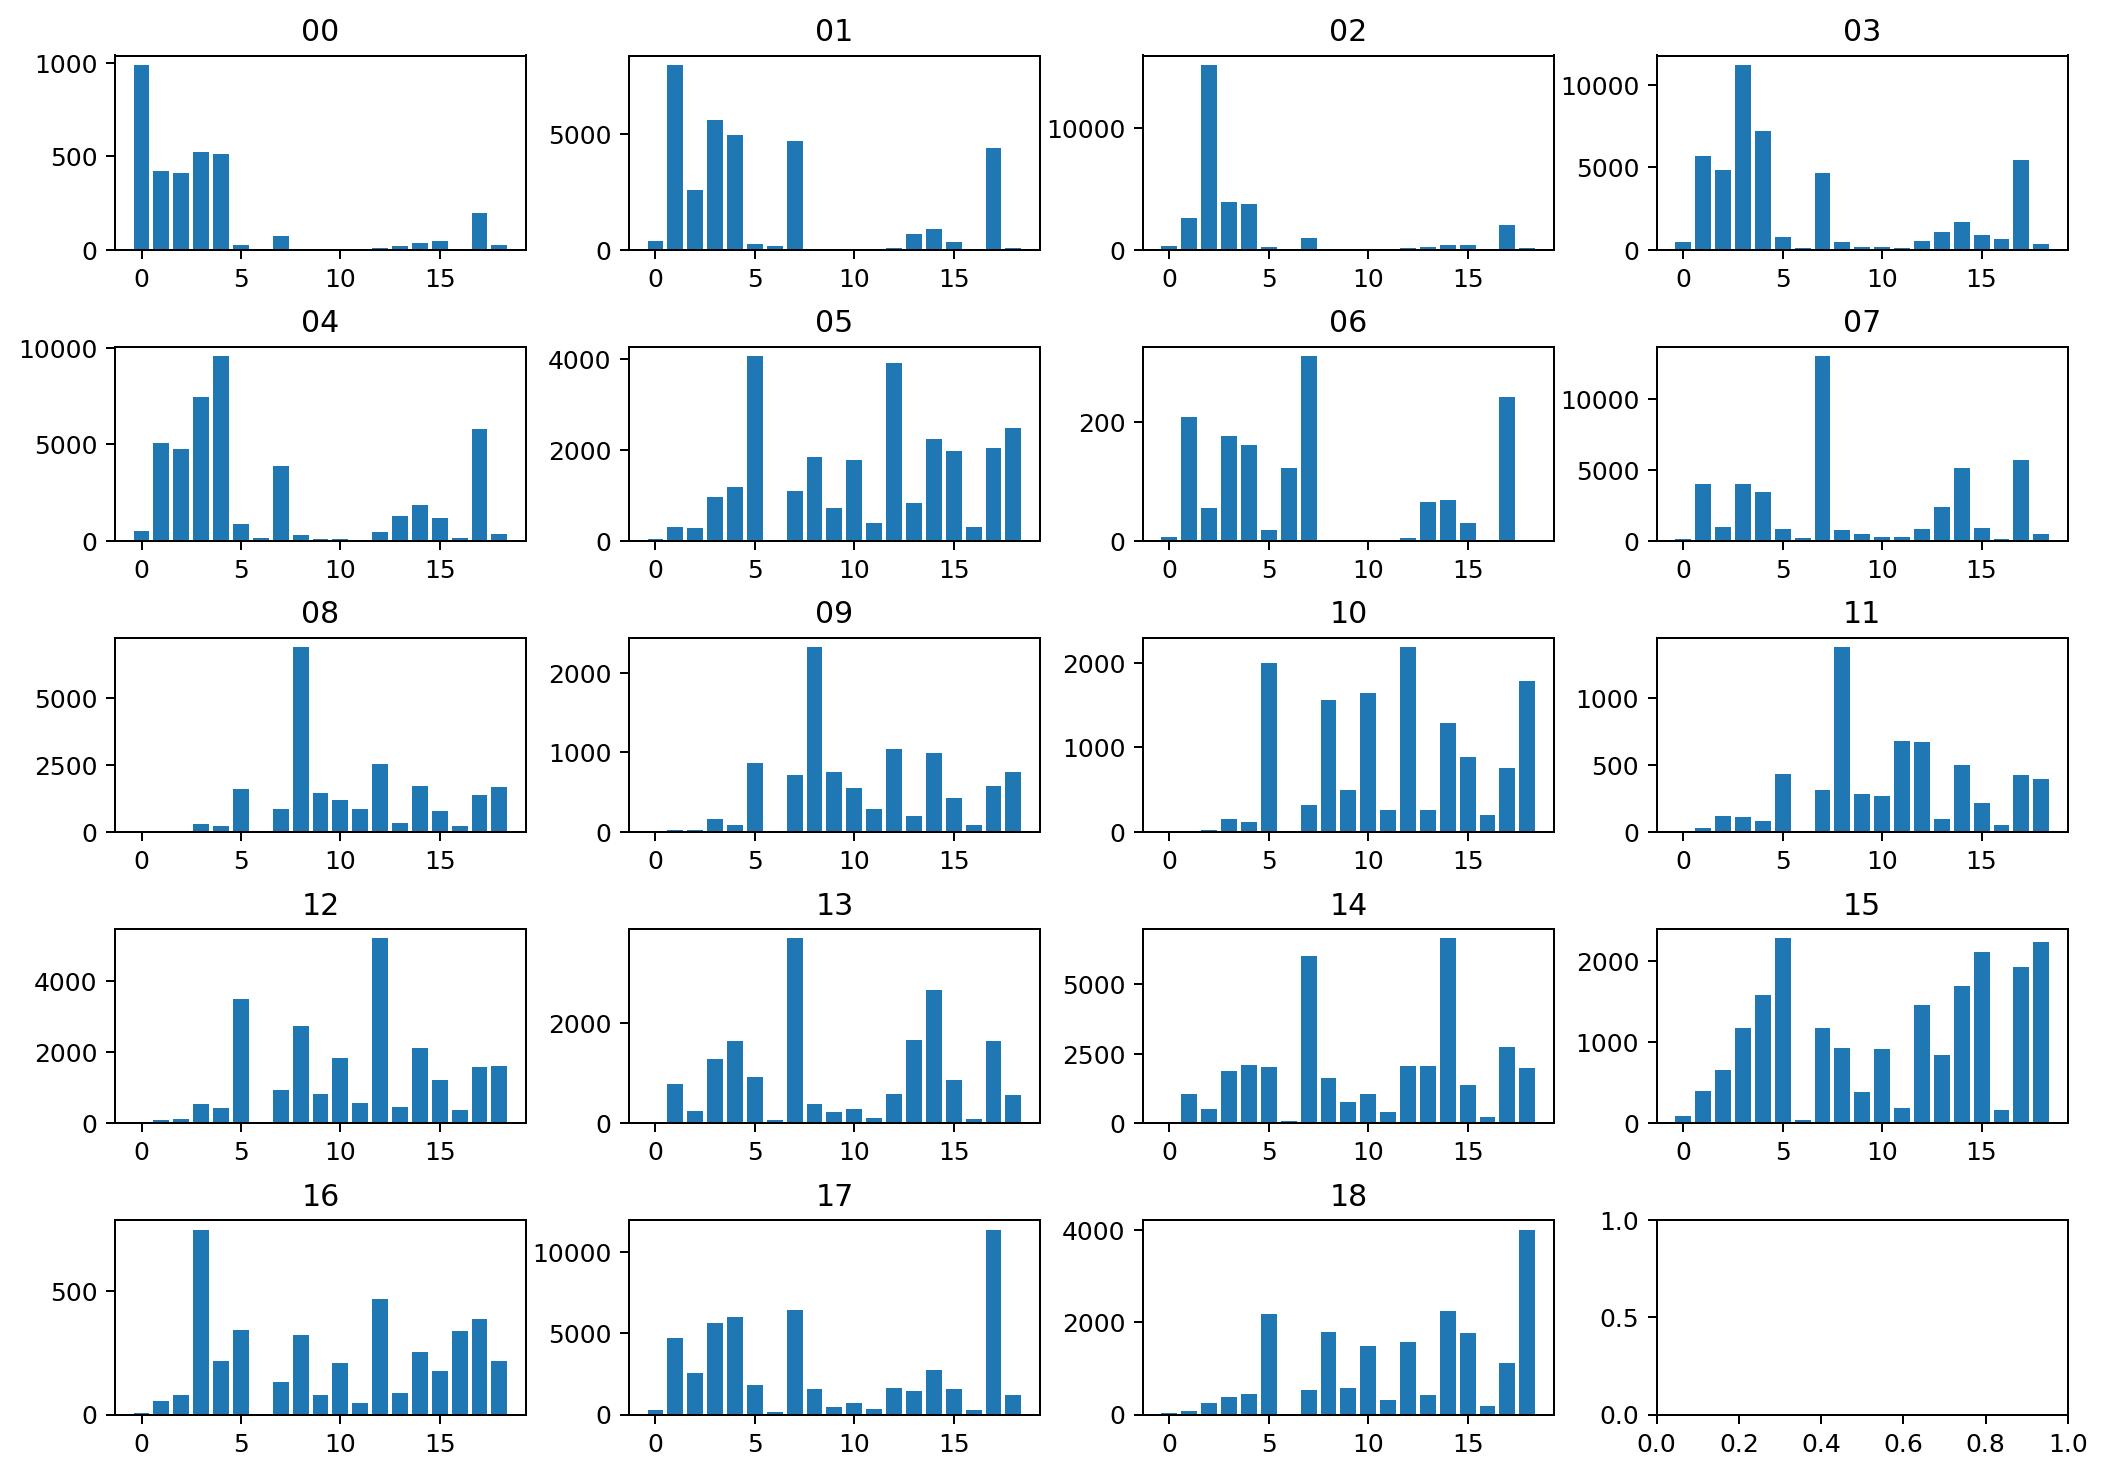

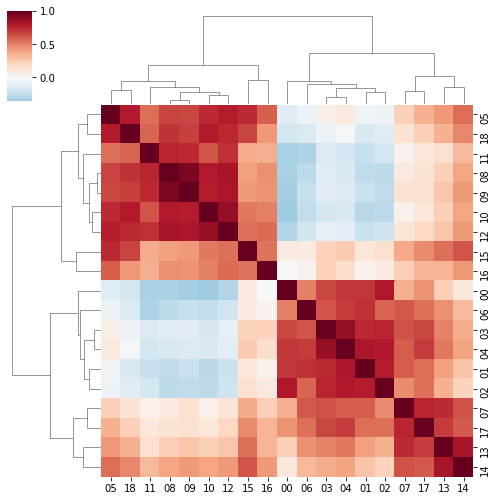

In [80]:
group_id = 'mean_leiden'
u_groups = np.unique(ad.obs[group_id])
ncols = 4
nrows = int(np.ceil(len(u_groups)/ncols))


meta_clusters = np.zeros((len(u_groups), len(u_groups)))

fig, axs = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 2*nrows), dpi=180,
                        gridspec_kw = dict(hspace=0.5, wspace=0.25))

coords = ad.obsm['coordinates']
indices = get_neighbors(coords)
for i, (g, ax) in enumerate(zip(u_groups, axs.ravel())):
    neighbors = pull_neighbors(indices, ad.obs[group_id], g) 
    vals, counts = np.unique(np.array(ad.obs.loc[neighbors, group_id]), return_counts=True)

    # counts vector considering the possibility of missing values in the neighbor set
    neighbor_counts = np.zeros(len(u_groups))
    for j,k in enumerate(u_groups):
        if (vals==k).sum() == 0:
            continue
        neighbor_counts[j] = counts[vals==k]

    ax.bar(np.arange(len(u_groups)), neighbor_counts)
    ax.set_title(g)
        
    meta_clusters[i,:] = neighbor_counts
    
sns.clustermap(pd.DataFrame(meta_clusters, index=u_groups, columns=u_groups).T.corr(method='kendall'), 
               cmap='RdBu_r', center=0, figsize=(7,7))